In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers.legacy import Optimizer
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2

import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler


In [ ]:
data = pd.read_csv('Indian ATM preprocessed.csv')
data


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.420395,-0.304479,0.120964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,503400.0
1,-1.296688,-1.199232,-1.463074,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,123800.0
2,-0.858541,-1.074961,-0.911767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,287700.0
3,2.628376,2.255508,1.078115,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,945300.0
4,2.409303,-0.031083,-0.276599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,767900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,-0.402139,0.093189,0.346663,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,498300.0
12671,-0.055272,-0.602730,-0.102665,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,544800.0
12672,0.547179,-0.329333,-0.135278,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,608600.0
12673,0.072520,0.267168,1.646505,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,902500.0


In [ ]:
tr = int(len(data) * 0.8)

X, y = data.iloc[:, :32], data.iloc[:, 32]

X_train, X_test = X[:tr], X[tr:]
y_train, y_test = y[:tr], y[tr:]

In [ ]:
y_mean = np.mean(y_train)
y_std = np.std(y_train)

y_test_normalized = (y_test - y_mean) / y_std
y_train_normalized = (y_train - y_mean) / y_std

In [ ]:
# hyperparameters
lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.05  # capturing (1-alpha)% of samples
soften_ = 100
n_ = 64 # batch size

# define loss fn
def qd_objective(y_true, y_pred):

    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)

    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)

    return Loss_S

In [ ]:
def plot(y_train, y_test, lower_bound, upper_bound):

    test_len = 100
    train_len = len(y_train) - 300
    X_axis = range(train_len + test_len)

    plt.figure(figsize=(20,8))

    plt.fill_between(
        range(300, 400),
        lower_bound.flatten()[:test_len],
        upper_bound.flatten()[:test_len],
        color="orange",
        alpha=0.9,
        label="95% Prediction Interval",
        zorder=1
    )

    plt.plot(range(300), y_train[train_len:], color='blue', zorder=2, label = 'Original Value')
    plt.plot(range(300, 400), y_test[:test_len], color='blue', zorder=2)


    plt.legend()
    plt.xlabel("Timeline")
    plt.ylabel("Transaction Amount")
    plt.title(f"Prediction Intervals using QD Loss")
    plt.show()


In [ ]:
num_features = X_train.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2),
          kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2),
          kernel_regularizer=l2(1e-4)),
    Dropout(0.25),
    Dense(2, activation='linear', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[3.,-3.])) # important to init biases to start!
])


# Compile the model with pinball loss for quantile regression
opt = keras.optimizers.Adam(learning_rate=0.005, decay=0.01)
model.compile(optimizer=opt, loss=qd_objective, metrics=['mae'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,658 (26.01 KB)

 Trainable params: 6,530 (25.51 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = model.fit(X_train, y_train_normalized, epochs=500, batch_size=n_, verbose=1, validation_data=(X_test, y_test_normalized))

Epoch 1/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.8383 - mae: 2.4341 - val_loss: 5.7650 - val_mae: 1.5355
Epoch 2/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2368 - mae: 2.2329 - val_loss: 3.8456 - val_mae: 1.8105
Epoch 3/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4853 - mae: 1.9379 - val_loss: 3.2559 - val_mae: 1.2774
Epoch 4/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5363 - mae: 1.4032 - val_loss: 2.5328 - val_mae: 1.2542
Epoch 5/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3263 - mae: 1.4116 - val_loss: 2.1812 - val_mae: 1.0450
Epoch 6/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8531 - mae: 1.2736 - val_loss: 4.6207 - val_mae: 0.8210
Epoch 7/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7639 - mae: 1.2373 - val_loss: 2.4868 - val_mae: 1.2230
Epoch 8/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5467 - mae: 1.1540 - val_loss: 2.1899 - val_mae: 1.0815
Epoch 9/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

In [ ]:
model.save('QD_PI.keras')
model.save('QD_PI.h5')

with open('QD_PI', 'wb') as file:

    pickle.dump(model, file)

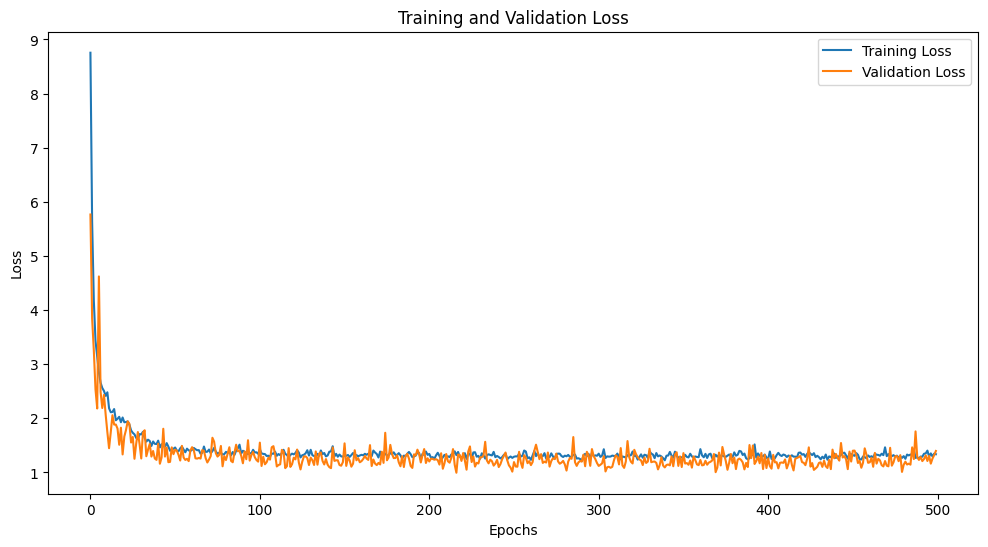

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# plot and view some predictions
y_pred = model.predict(X_test, verbose=0)

y_pred_denorm = y_pred * y_std + y_mean

upper_bound = y_pred_denorm[:,0].flatten()
lower_bound = y_pred_denorm[:,1].flatten()
mean_pred = (upper_bound + lower_bound) / 2

outcome = (y_test > lower_bound) & (y_test < upper_bound)

outcome = outcome.apply(lambda x: 0 if x ==True else 1)
result = pd.DataFrame({'Original': y_test, 'Predicted': mean_pred,
                        'Lower Bound': lower_bound, 'Upper Bound': upper_bound,
                      'Outcome': outcome})

result.to_csv(f'Results_QD.csv', index=False)


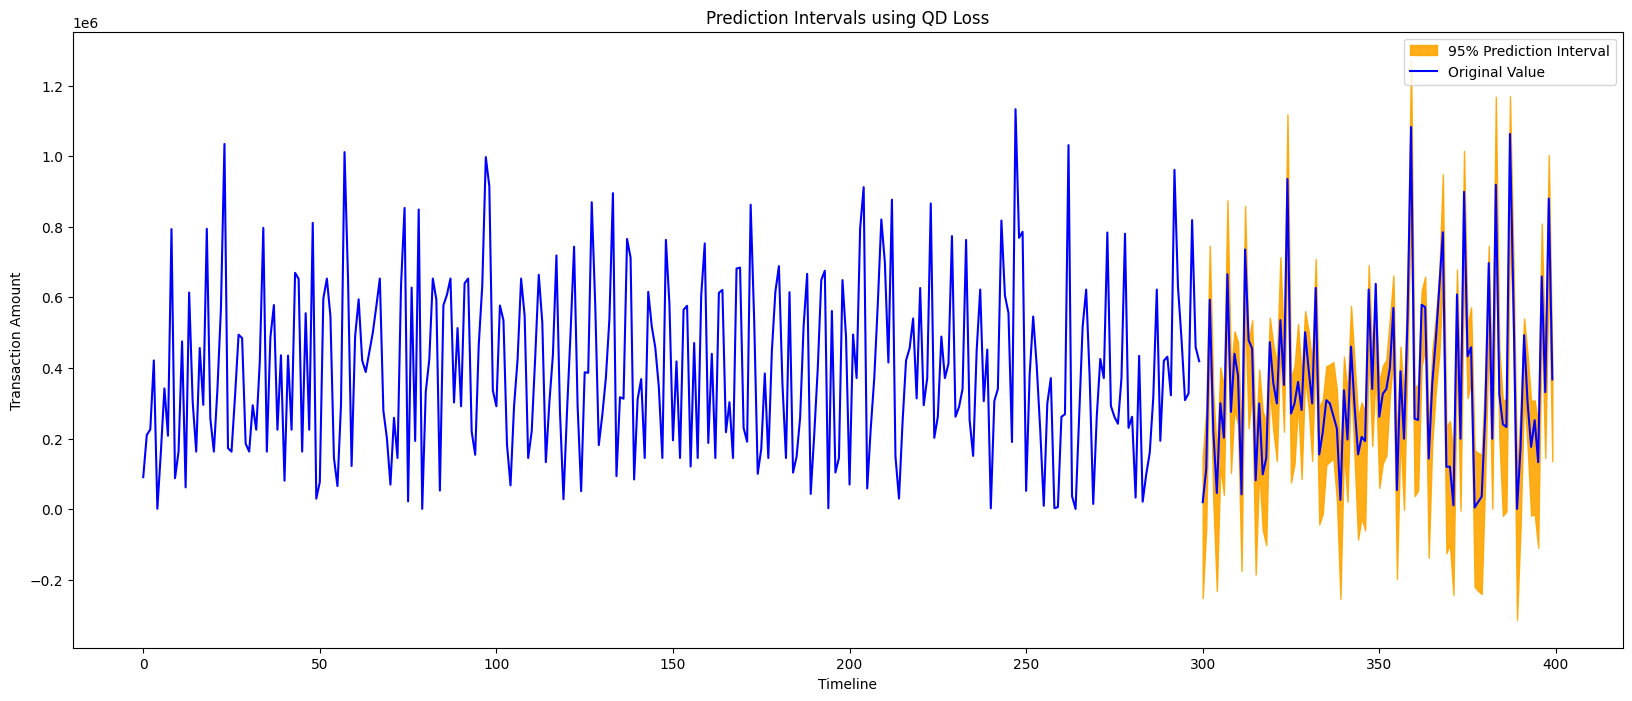

In [ ]:
plot(y_train, y_test, lower_bound, upper_bound)

In [ ]:

# Check if true targets fall within the PIs
within_pi = (y_test >= lower_bound) & (y_test <= upper_bound)

# Calculate PICP
PICP = np.mean(within_pi)

# print("\nConfidence Interval: ", PICP)
print("\nPrediction Interval Coverage Probability (PICP):", PICP)

# Calculate the width of the prediction intervals
pi_width = upper_bound - lower_bound

# Calculate MPIW
MPIW = np.mean(pi_width)
print("Mean Prediction Interval Width (MPIW):", MPIW)



Prediction Interval Coverage Probability (PICP): 0.9597633136094674
Mean Prediction Interval Width (MPIW): 279418.4
